# 09 Clustering Specific Companies

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import re, csv, os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from joblib import parallel_backend
from dask.distributed import Client
import joblib
import nltk
import concurrent.futures as cf
from glob import glob
from sklearn.preprocessing import FunctionTransformer


pd.set_option('display.max_columns', None)
csv.field_size_limit(10000000)

%matplotlib inline

In [27]:
client = Client(processes=False)

In [10]:
path = 'filtered_data'
path_out = 'results'

In [11]:
col_names = ['JobID', 'CleanJobTitle', 'CanonCity', 'CanonState', 'CanonPostalCode',
             'BGTOcc', 'clean_text', 'EmployerClean', 'JobDate']

dtypes={'JobID': np.str, 'CanonJobTitle': np.str, 'EmployerClean': np.str,
        'CleanJobTitle': np.str, 'CanonCity': np.str, 'CanonCounty': np.str,
        'CanonState': np.str, 'ConsolidatedTitle': np.str, 'BGTOcc': np.str,
        'JobDate': np.str, 'CanonPostalCode': np.str}

In [12]:
to_remove = ['Assistant Manager', 'Deputy Manager', 'Manager', 'Senior Manager', 'General Manager', 'Assistant Director',
             'Deputy Director', 'Director', 'Senior Director', 'Deputy Vice President', 'Vice President', 'Senior Vice President',
             'President', 'Chief']
to_remove_low = [word.lower() for word in to_remove]

In [13]:
def remove_titles(doc):
    tokens = nltk.word_tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in to_remove_low]
    clean = ' '.join(filtered_tokens)
    return clean

def normalize_doc(doc):
    """
    This function normalizes your list of documents by taking only
    words, numbers, and spaces in between them. It then filters out
    stop words if you want to.
    """
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    tokens = nltk.word_tokenize(doc)
    filtered_tokens = [token for token in tokens]
    # filtered_tokens = [token for token in tokens if token not in stop_words]
    doc = ' '.join(filtered_tokens)
    return doc

corp_normalizer = np.vectorize(normalize_doc)

In [15]:
files = glob(os.path.join(path, 'fil*', '*.csv'))
files[:10]

['filtered_data/filtered_data_11/data_filtered_32.csv',
 'filtered_data/filtered_data_11/data_filtered_25.csv',
 'filtered_data/filtered_data_11/data_filtered_02.csv',
 'filtered_data/filtered_data_11/data_filtered_41.csv',
 'filtered_data/filtered_data_11/data_filtered_42.csv',
 'filtered_data/filtered_data_11/data_filtered_44.csv',
 'filtered_data/filtered_data_11/data_filtered_47.csv',
 'filtered_data/filtered_data_11/data_filtered_19.csv',
 'filtered_data/filtered_data_11/data_filtered_15.csv',
 'filtered_data/filtered_data_11/data_filtered_46.csv']

In [17]:
%%time


def get_files(file):
    return pd.read_csv(file, usecols=col_names, low_memory=False)


with cf.ProcessPoolExecutor() as executor:
    results = executor.map(get_files, files)
    
df = pd.concat(results)
df.reset_index(drop=True, inplace=True)
df.head()

CPU times: user 1min 15s, sys: 4min 28s, total: 5min 44s
Wall time: 10min 28s


,CanonCity,CanonState,CleanJobTitle,JobDate,JobID,CanonPostalCode,BGTOcc,EmployerClean,clean_text
0,Arlington,TX,Nurse Extern - Subacute Intensive Care Unit - Pt,2011-08-23,280985108,10483,29-1141.03,Texas Health Resources,"to access account status, saved documents and..."
1,Boca Raton,FL,Shift Leader 10 Park Road,2011-08-26,282733305,-32105,41-1011.00,Blockbuster Inc.,Job: IRC34902 Attention: This site does not su...
2,Clearwater,FL,Home Health Aide/Contract,2011-08-26,277546261,-31780,31-1011.00,Baycare Health System,Go to the main content section. Welcome. You a...
3,Eugene,OR,Pulp & Paper Engineer,2011-08-26,283794957,31872,17-2141.00,Evergreen Engineering,Ads by Google Pulp & Paper Engineer Apply Now ...
4,Richardson,TX,Pharmacy Service Associate Psa,2011-08-20,288751877,9544,41-2031.00,CVS Health,Pharmacy Service Associate (PSA) - As the firs...


In [60]:
# ddf = dd.read_csv(os.path.join(path, 'da*.csv'), 
#                  engine='python',
#                  dtype=dtypes,
#                  assume_missing=True,
#                  error_bad_lines=False,
#                  blocksize=None,
#                  usecols=col_names,
#                 )
# ddf

In [61]:
# ddf1 = ddf.map_partitions(lambda data: data.drop_duplicates(subset='CleanJobTitle'))

In [62]:
# df = pd.read_csv(path + f'data_filtered_{fil_num}.csv', low_memory=False, usecols=col_names, dtype=dtypes).drop_duplicates(subset='CleanJobTitle')
# df.head()

,CanonCity,CanonState,CleanJobTitle,JobDate,JobID,CanonPostalCode,BGTOcc,EmployerClean,clean_text
0,Providence,RI,Ae - Sales Leader - Us,2020-03-26,38736286783,02901,41-2031.00,American Eagle Outfitters,AE - Sales Leader - US at American Eagle Outfi...
1,Wilmington,DE,Respiratory Therapist Rt - Sign,2020-03-26,38736274856,19801,29-1126.00,Select Medical,"Respiratory Therapist (RT)- $7,500 Sign-On Bon..."
2,Atlanta,GA,Food Service Worker- Institute Of Technology- ...,2020-03-26,38736626685,30301,35-3021.00,Aramark,Job Information\n\nARAMARK Food Service Worker...
3,Memphis,TN,Research Echo Sonographer,2020-03-26,38736626694,37501,29-2032.00,St. Jude Children's Research Hospital,Job Information\n\nSt. Jude Children's Researc...
4,Fort Worth,TX,Pbx Operator,2020-03-26,38736627489,76101,43-2011.00,Jps Health Network,PBX Operator\n\nJPS Health Network\n\nFort Wor...


Before Removing Duplicates

In [9]:
df.shape

(29646362, 9)

In [19]:
%%time

df = df.drop_duplicates(subset='CleanJobTitle')

CPU times: user 24.7 s, sys: 16.9 s, total: 41.6 s
Wall time: 41.6 s


After Removing Duplicates

In [20]:
df.shape

(6706926, 9)

In [21]:
%%time

df = df.sample(1_000_000).copy()
df.shape

CPU times: user 2.36 s, sys: 259 ms, total: 2.62 s
Wall time: 2.62 s


(1000000, 9)

In [22]:
%%time

X_train, y_test = train_test_split(df, test_size=.2, random_state=42, shuffle=True)

X_train_2, y_test_2 = X_train.copy(), y_test.copy()

CPU times: user 1.01 s, sys: 27.4 ms, total: 1.03 s
Wall time: 1.03 s


In [23]:
X_train_2.head()

,CanonCity,CanonState,CleanJobTitle,JobDate,JobID,CanonPostalCode,BGTOcc,EmployerClean,clean_text
24851687,Phoenix,AZ,Program Project Specialist II,2012-07-18,145066593,85087,15-1199.09,Des,Job ID 1000069233 Req Name ADCSL1000068058A Lo...
11171478,Middleton,WI,Registered Nurse Union Corners Pediatrics - C4,2016-12-02,38151984245,53562,29-1141.00,Uw Medical Foundation,Registered Nurse Union Corners Pediatrics - 16...
6161334,New York,NY,Park Animal Hospital,2019-07-05,38554296335,10001,43-1011.95,Pet Partners,Park East Animal Hospital\n\nPet Partners - Ne...
15658362,Bremerton,WA,Monitor Technician - Pcu - Medical Center,2015-12-18,37989590552,98310,29-2031.00,Catholic Health Initiatives,Monitor Tech - PCU - 24 hours per week (.6 FTE...
24196160,Columbus,OH,Systems Administrative Local To In-Person Inte...,2017-10-11,38286939560,43085,15-1142.00,Devcare Solutions,system Admin (Local to OH) (in-Person Intervie...


In [24]:
%%time

rm_titles = np.vectorize(remove_titles)
X_train_2['CleanJobTitle'] = rm_titles(X_train_2['CleanJobTitle'].str.lower().values)
y_test_2['CleanJobTitle'] = rm_titles(y_test_2['CleanJobTitle'].str.lower().values)
y_test_2.head()

CPU times: user 2min 28s, sys: 343 ms, total: 2min 28s
Wall time: 2min 28s


,CanonCity,CanonState,CleanJobTitle,JobDate,JobID,CanonPostalCode,BGTOcc,EmployerClean,clean_text
171905,Sunnyside,FL,fuels systems facilities project support analyst,2011-11-01,9363043,32461,15-1121.00,Booz Allen Hamilton Inc.,Go to the main content section. Job Opport...
16513775,Tucson,AZ,now plant operator hot plant oiler,2015-07-26,37928933435,85701,51-8099.00,Axxis Advertising,Ashton Is Now Hiring: Hot Plant Operator Hot P...
25172306,Hartford,CT,"advanced practice registered nurse , or",2012-03-14,103796161,6102,29-1171.00,Connecticut Multispecialty Group,Hartford City Guide / / Advanced Practice Reg...
2053555,White Marsh,MD,operational services specialist,2018-03-31,38344952208,21162,15-2031.00,Prometric,We are now hiring\nReq #1307\nOperational Serv...
22682094,Mountain View,CA,senior product - payroll,2017-09-26,38280750346,94035,11-2021.92,Intuit,# Senior Product Manager - Payroll\n\nQuickBoo...


In [25]:
preprocessing = Pipeline([
    ('normalizer', FunctionTransformer(corp_normalizer)),
    ('vect', TfidfVectorizer(ngram_range=(1, 1), min_df=10, max_df=.85))
])

km_pipe = Pipeline([
    ('km', KMeans(n_clusters=100, # how many clusters do we want
            max_iter=1000, # reshuffle each centroid x number of times
            n_init=15, # that x num of times can be set here
            random_state=42,
            n_jobs=-1))
])

pipe = Pipeline([
    ('preprocessor', preprocessing),
    ('km_model', km_pipe)
])

##############################################################################

preprocessing2 = Pipeline([
    ('normalizer2', FunctionTransformer(corp_normalizer)),
    ('vect2', TfidfVectorizer(ngram_range=(1, 1), min_df=10, max_df=.85))
])

km_pipe2 = Pipeline([
    ('km2', KMeans(n_clusters=100, # how many clusters do we want
            max_iter=1000, # reshuffle each centroid x number of times
            n_init=15, # that x num of times can be set here
            random_state=42,
            n_jobs=-1))
])

pipe2 = Pipeline([
    ('preprocessor2', preprocessing2),
    ('km_model2', km_pipe2)
])

##############################################################################

preprocessing3 = Pipeline([
    ('normalizer3', FunctionTransformer(corp_normalizer)),
    ('vect3', TfidfVectorizer(ngram_range=(1, 2), min_df=10, max_df=.85))
])

km_pipe3 = Pipeline([
    ('km3', KMeans(n_clusters=100, # how many clusters do we want
            max_iter=1000, # reshuffle each centroid x number of times
            n_init=15, # that x num of times can be set here
            random_state=42,
            n_jobs=-1))
])

pipe3 = Pipeline([
    ('preprocessor3', preprocessing3),
    ('km_model3', km_pipe3)
])

##############################################################################

preprocessing4 = Pipeline([
    ('normalizer4', FunctionTransformer(corp_normalizer)),
    ('vect4', TfidfVectorizer(ngram_range=(1, 2), min_df=10, max_df=.85))
])

km_pipe4 = Pipeline([
    ('km4', KMeans(n_clusters=100, # how many clusters do we want
            max_iter=1000, # reshuffle each centroid x number of times
            n_init=15, # that x num of times can be set here
            random_state=42,
            n_jobs=-1))
])

pipe4 = Pipeline([
    ('preprocessor4', preprocessing4),
    ('km_model4', km_pipe4)
])

In [32]:
%%time

with joblib.parallel_backend('dask'):
#     pipe.fit(X_train['CleanJobTitle'].values);
#     preprocessed_data = pipe.transform(X_train['CleanJobTitle'].values);
#     joblib.dump(pipe, f'models/uni_titles_500c_pipe.pkl');
#     print("Done with Pipe 1")
    
#     pipe2.fit(X_train_2['CleanJobTitle'].values);
#     preprocessed_data2 = pipe2.transform(X_train_2['CleanJobTitle'].values);
#     joblib.dump(pipe2, f'models/uni_no_titles_500c_pipe.pkl');
#     print("Done with Pipe 2")
    
    pipe3.fit(X_train['CleanJobTitle'].values);
    preprocessed_dat3 = pipe3.transform(X_train['CleanJobTitle'].values);
    joblib.dump(pipe3, f'models/bi_titles_500c_pipe.pkl');
    print("Done with Pipe 3")
    
    pipe4.fit(X_train_2['CleanJobTitle'].values);
    preprocessed_data4 = pipe4.transform(X_train_2['CleanJobTitle'].values);
    joblib.dump(pipe4, f'models/bi_no_titles_500c_pipe.pkl');
    print("Done with Pipe 4")

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Done with Pipe 3


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Done with Pipe 4
CPU times: user 15h 2min 39s, sys: 22h 5s, total: 1d 13h 2min 45s
Wall time: 1h 50min 37s


## With Titles

In [33]:
pipe['km_model']['km'].labels_[:10]

array([92, 94,  0,  1, 53, 94, 18,  0, 47, 60], dtype=int32)

In [34]:
clusters = pipe['km_model']['km'].labels_
X_train['clusters'] = clusters
X_train['distance'] = preprocessed_data.sum(axis=1).round(2)
X_train['dist_dummy'] = np.where(X_train['distance'] < np.percentile(X_train['distance'], 5), 1, 0)

test_transformed = pipe['preprocessor'].transform(y_test['CleanJobTitle'].values)
test_predict = pipe['km_model'].predict(test_transformed)
y_test['predictions'] = test_predict
y_test['distance'] = test_transformed.sum(axis=1).round(2)
y_test['dist_dummy'] = np.where(y_test['distance'] < np.percentile(y_test['distance'], 5), 1, 0)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [36]:
clusters3 = pipe3['km_model3']['km3'].labels_
X_train['clusters_bi'] = clusters3
X_train['distance_bi'] = preprocessed_dat3.sum(axis=1).round(2)
X_train['dist_dummy_bi'] = np.where(X_train['distance_bi'] < np.percentile(X_train['distance_bi'], 5), 1, 0)

test_transformed3 = pipe3['preprocessor3'].transform(y_test['CleanJobTitle'].values)
test_predict3 = pipe3['km_model3'].predict(test_transformed3)
y_test['predictions_bi'] = test_predict3
y_test['distance_bi'] = test_transformed3.sum(axis=1).round(2)
y_test['dist_dummy_bi'] = np.where(y_test['distance_bi'] < np.percentile(y_test['distance_bi'], 5), 1, 0)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

## Without Titles

In [37]:
pipe2['km_model2']['km2'].labels_[:10]

array([74, 28,  0, 94, 72, 62, 77,  0,  9, 94], dtype=int32)

In [38]:
clusters2 = pipe2['km_model2']['km2'].labels_
X_train_2['clusters2'] = clusters2
X_train_2['distance2'] = preprocessed_data2.sum(axis=1).round(2)
X_train_2['dist_dummy2'] = np.where(X_train_2['distance2'] < np.percentile(X_train_2['distance2'], 5), 1, 0)

test_transformed2 = pipe2['preprocessor2'].transform(y_test_2['CleanJobTitle'].values)
test_predict2 = pipe2['km_model2'].predict(test_transformed2)
y_test_2['predictions2'] = test_predict2
y_test_2['distance2'] = test_transformed2.sum(axis=1).round(2)
y_test_2['dist_dummy2'] = np.where(y_test_2['distance2'] < np.percentile(y_test_2['distance2'], 5), 1, 0)

In [39]:
clusters4 = pipe4['km_model4']['km4'].labels_
X_train_2['clusters2_bi'] = clusters4
X_train_2['distance2_bi'] = preprocessed_data4.sum(axis=1).round(2)
X_train_2['dist_dummy2_bi'] = np.where(X_train_2['distance2_bi'] < np.percentile(X_train_2['distance2_bi'], 5), 1, 0)

test_transformed4 = pipe4['preprocessor4'].transform(y_test_2['CleanJobTitle'].values)
test_predict4 = pipe4['km_model4'].predict(test_transformed4)
y_test_2['predictions2_bi'] = test_predict4
y_test_2['distance2_bi'] = test_transformed4.sum(axis=1).round(2)
y_test_2['dist_dummy2_bi'] = np.where(y_test_2['distance2_bi'] < np.percentile(y_test_2['distance2_bi'], 5), 1, 0)

Back into the main Dataset

In [40]:
X_train['clusters2'] = clusters2
X_train['distance2'] = preprocessed_data2.sum(axis=1).round(2)
X_train['dist_dummy2'] = np.where(X_train_2['distance2'] < np.percentile(X_train_2['distance2'], 5), 1, 0)

y_test['predictions2'] = test_predict2
y_test['distance2'] = test_transformed2.sum(axis=1).round(2)
y_test['dist_dummy2'] = np.where(y_test_2['distance2'] < np.percentile(y_test_2['distance2'], 5), 1, 0)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [41]:
X_train['clusters2_bi'] = clusters4
X_train['distance2_bi'] = preprocessed_data4.sum(axis=1).round(2)
X_train['dist_dummy2_bi'] = np.where(X_train_2['distance2_bi'] < np.percentile(X_train_2['distance2_bi'], 5), 1, 0)

y_test['predictions2_bi'] = test_predict4
y_test['distance2_bi'] = test_transformed4.sum(axis=1).round(2)
y_test['dist_dummy2_bi'] = np.where(y_test_2['distance2_bi'] < np.percentile(y_test_2['distance2_bi'], 5), 1, 0)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [42]:
X_train.head()

,CanonCity,CanonState,CleanJobTitle,JobDate,JobID,CanonPostalCode,BGTOcc,EmployerClean,clean_text,clusters,distance,dist_dummy,clusters_bi,distance_bi,dist_dummy_bi,clusters2,distance2,dist_dummy2,clusters2_bi,distance2_bi,dist_dummy2_bi
24851687,Phoenix,AZ,Program Project Specialist II,2012-07-18,145066593,85087,15-1199.09,Des,Job ID 1000069233 Req Name ADCSL1000068058A Lo...,92,110.19,0,94,109.70,0,74,110.51,0,89,108.98,0
11171478,Middleton,WI,Registered Nurse Union Corners Pediatrics - C4,2016-12-02,38151984245,53562,29-1141.00,Uw Medical Foundation,Registered Nurse Union Corners Pediatrics - 16...,94,110.95,0,6,109.51,0,28,111.31,0,49,109.05,0
6161334,New York,NY,Park Animal Hospital,2019-07-05,38554296335,10001,43-1011.95,Pet Partners,Park East Animal Hospital\n\nPet Partners - Ne...,0,111.63,0,5,110.09,0,0,111.91,0,3,109.52,0
15658362,Bremerton,WA,Monitor Technician - Pcu - Medical Center,2015-12-18,37989590552,98310,29-2031.00,Catholic Health Initiatives,Monitor Tech - PCU - 24 hours per week (.6 FTE...,1,110.70,0,15,109.54,0,94,111.09,0,28,109.05,0
24196160,Columbus,OH,Systems Administrative Local To In-Person Inte...,2017-10-11,38286939560,43085,15-1142.00,Devcare Solutions,system Admin (Local to OH) (in-Person Intervie...,53,111.42,0,5,109.90,0,72,111.66,0,3,109.33,0


In [43]:
y_test.head()

,CanonCity,CanonState,CleanJobTitle,JobDate,JobID,CanonPostalCode,BGTOcc,EmployerClean,clean_text,predictions,distance,dist_dummy,predictions_bi,distance_bi,dist_dummy_bi,predictions2,distance2,dist_dummy2,predictions2_bi,distance2_bi,dist_dummy2_bi
171905,Sunnyside,FL,Fuels Systems Facilities Project Support Analyst,2011-11-01,9363043,32461,15-1121.00,Booz Allen Hamilton Inc.,Go to the main content section. Job Opport...,53,2.29,0,83,2.82,0,99,2.29,0,84,2.82,0
16513775,Tucson,AZ,Now Plant Operator Hot Plant Oiler,2015-07-26,37928933435,85701,51-8099.00,Axxis Advertising,Ashton Is Now Hiring: Hot Plant Operator Hot P...,87,1.60,0,33,1.88,0,91,1.60,0,73,1.88,0
25172306,Hartford,CT,"Advanced Practice Registered Nurse, Or",2012-03-14,103796161,6102,29-1171.00,Connecticut Multispecialty Group,Hartford City Guide / / Advanced Practice Reg...,86,2.13,0,6,2.80,0,28,2.13,0,70,2.81,0
2053555,White Marsh,MD,Operational Services Specialist,2018-03-31,38344952208,21162,15-2031.00,Prometric,We are now hiring\nReq #1307\nOperational Serv...,82,1.64,0,16,1.90,0,31,1.64,0,33,1.90,0
22682094,Mountain View,CA,Senior Product Manager - Payroll,2017-09-26,38280750346,94035,11-2021.92,Intuit,# Senior Product Manager - Payroll\n\nQuickBoo...,61,1.89,0,97,2.46,0,23,1.67,0,0,1.94,0


Save Trained Pipelines

# Switch to Dask before saving and save multiple files

In [44]:
import dask.dataframe as dd

In [45]:
X_train.shape, y_test.shape, X_train_2.shape, y_test_2.shape

((800000, 21), (200000, 21), (800000, 15), (200000, 15))

In [53]:
%%time

ddf_train = dd.from_pandas(X_train, npartitions=5)
ddf_test = dd.from_pandas(y_test, npartitions=5)
ddf_train_2 = dd.from_pandas(X_train_2, npartitions=5)
ddf_test_2 = dd.from_pandas(y_test_2, npartitions=5)

CPU times: user 14 s, sys: 2.55 s, total: 16.5 s
Wall time: 16.1 s


In [54]:
%%time

if not os.path.exists(os.path.join(path_out, 'with_all_titles')):
    os.makedirs(os.path.join(path_out, 'with_all_titles'))

(ddf_train
 .repartition(npartitions=3)
 .to_csv(os.path.join(path_out, 'with_all_titles/', 'train_titles_500c_*.csv'), index=False)
 )

(ddf_test
 .repartition(npartitions=3)
 .to_csv(os.path.join(path_out, 'with_all_titles/', 'test_titles_500c_*.csv'), index=False)
 )

CPU times: user 1min 30s, sys: 13.8 s, total: 1min 44s
Wall time: 1min 36s


['/home/ubuntu/results/with_all_titles/test_titles_500c_0.csv',
 '/home/ubuntu/results/with_all_titles/test_titles_500c_1.csv',
 '/home/ubuntu/results/with_all_titles/test_titles_500c_2.csv']

In [55]:
y_test_2.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 171905 to 8335645
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   CanonCity        200000 non-null  object        
 1   CanonState       200000 non-null  object        
 2   CleanJobTitle    200000 non-null  object        
 3   JobDate          200000 non-null  datetime64[ns]
 4   JobID            200000 non-null  int64         
 5   CanonPostalCode  200000 non-null  object        
 6   BGTOcc           200000 non-null  object        
 7   EmployerClean    200000 non-null  object        
 8   clean_text       200000 non-null  object        
 9   predictions2     200000 non-null  int32         
 10  distance2        200000 non-null  float64       
 11  dist_dummy2      200000 non-null  int64         
 12  predictions2_bi  200000 non-null  int32         
 13  distance2_bi     200000 non-null  float64       
 14  dist_dummy2_bi

In [56]:
%%time

if not os.path.exists(os.path.join(path_out, 'without_titles')):
    os.makedirs(os.path.join(path_out, 'without_titles'))

(ddf_train_2
 .repartition(npartitions=1)
 .to_csv(os.path.join(path_out, 'without_titles/', 'train_no_titles_500c_*.csv'), index=False)
 )

(ddf_test_2
 .repartition(npartitions=1)
 .to_csv(os.path.join(path_out, 'without_titles/', 'test_no_titles_500c_*.csv'), index=False)
 )

CPU times: user 1min 24s, sys: 6.81 s, total: 1min 31s
Wall time: 1min 29s


['/home/ubuntu/results/without_titles/test_no_titles_500c_0.csv']

In [ ]:
%%time

X_train.to_csv(path_out + '/clustering' + f'/train_titles_in_500c_{num}.csv', index=False)
y_test.to_csv(path_out + '/clustering' + f'/test_titles_in_500c_{num}.csv', index=False)
X_train_2.to_csv(path_out + '/clustering' + f'/train_titles_out_500c_{num}.csv', index=False)
y_test_2.to_csv(path_out + '/clustering' + f'/test_titles_out_500c_{num}.csv', index=False)

### Entropy Calculations

In [58]:
import numpy as np
from scipy.stats import entropy
from math import log, e
import pandas as pd

import timeit

def entropy1(labels, base=None):
    value,counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=base)

def entropy2(labels, base=None):
    """ Computes entropy of label distribution. """

    n_labels = len(labels)

    if n_labels <= 1:
        return 0

    value,counts = np.unique(labels, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    ent = 0.

    # Compute entropy
    base = e if base is None else base
    
    for i in probs:
        ent -= i * log(i, base)

    return ent

def entropy3(labels, base=None):
    vc = pd.Series(labels).value_counts(normalize=True, sort=False)
    base = e if base is None else base
    return -(vc * np.log(vc)/np.log(base)).sum()

def entropy4(labels, base=None):
    value,counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()
    base = e if base is None else base
    return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()


In [60]:
print(entropy2(X_train.clusters))
print(entropy2(X_train.clusters_bi))
print(entropy2(X_train.clusters2))
print(entropy2(X_train.clusters2_bi))

4.147756763504582
3.8797826353969835
4.045807618053301
3.8592578936772526


In [63]:
print(entropy2(y_test.predictions))
print(entropy2(y_test.predictions_bi))
print(entropy2(y_test.predictions2))
print(entropy2(y_test.predictions2_bi))

4.146796256683654
3.8860690669658844
4.0479650659415
3.86130124163429


In [66]:
ent_mss = [entropy2(X_train.clusters), entropy2(X_train.clusters_bi), entropy2(X_train.clusters2), entropy2(X_train.clusters2_bi), 
           entropy2(y_test.predictions), entropy2(y_test.predictions_bi), entropy2(y_test.predictions2), entropy2(y_test.predictions2_bi)]

ent_names = ['clusters', 'clusters_bi', 'clusters2', 'clusters2_bi', 'predictions', 'predictions_bi', 'predictions2', 'predictions2_bi']

data_sets = ['X_train', 'X_train', 'X_train', 'X_train', 'y_test', 'y_test', 'y_test', 'y_test']

entr = pd.DataFrame(zip(*[ent_mss, ent_names, data_sets]), columns=['entropy', 'clusters', 'datasets'])
entr

,entropy,clusters,datasets
0,4.147757,clusters,X_train
1,3.879783,clusters_bi,X_train
2,4.045808,clusters2,X_train
3,3.859258,clusters2_bi,X_train
4,4.146796,predictions,y_test
5,3.886069,predictions_bi,y_test
6,4.047965,predictions2,y_test
7,3.861301,predictions2_bi,y_test


array([<AxesSubplot:title={'center':'entropy'}, xlabel='clusters'>],
      dtype=object)

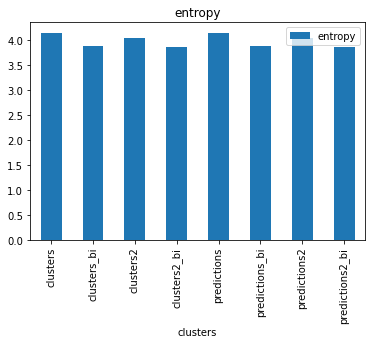

In [70]:
entr.plot(kind='bar', x='clusters', y='entropy')

In [74]:
import seaborn as sns

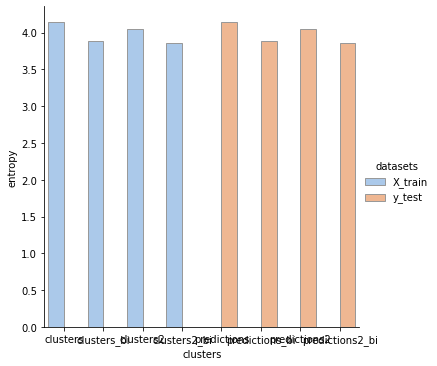

In [84]:
sns.catplot(y="entropy", x='clusters', hue="datasets", kind='bar',
            palette="pastel", edgecolor=".6",
            data=entr)

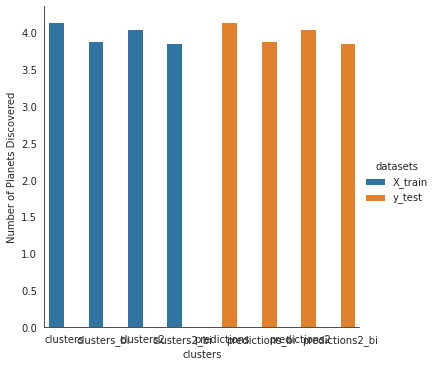

In [86]:
with sns.axes_style('white'):
    g = sns.catplot(y="entropy", x='clusters', data=entr, kind='bar',  hue='datasets')
    g.set_ylabels('Number of Planets Discovered')

In [93]:
!conda install -c conda-forge altair vega_datasets -y

Solving environment: done

## Package Plan ##

  environment location: /home/ubuntu/anaconda3

  added / updated specs:
    - altair
    - vega_datasets


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py37he5f6b98_2         151 KB  conda-forge
    conda-4.8.5                |   py37he5f6b98_3         3.0 MB  conda-forge
    openssl-1.1.1h             |       h516909a_0         2.1 MB  conda-forge
    vega_datasets-0.8.0        |             py_0         178 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         6.2 MB

The following NEW packages will be INSTALLED:

  altair             conda-forge/noarch::altair-4.1.0-p

In [94]:
import altair as alt

In [96]:
alt.Chart(entr).mark_bar().encode(
    x='clusters:O',
    y='entropy:Q',
    color='datasets:N',
#     column='clusters:N'
)

alt.Chart(...)